# Summary

The European Insurance and Occupational Pensions Authority (EIOPA) provide every month a yield curve for each relevant country. The curve is provided as a series of annual yield rates starting with 1 year and going all the way to 150. However, many use cases require a different granularity. This workbook uses the same Smith-Wilson algorithm together with EIOPA's own calibration vectors to generate the yield curve for any granularity. This avoids the need to implement a separate interpolation/extrapolation method. 

# Table of Contents  
 
1. Note on Smith & Wilson algorithm
2. Limitations of the implementation
3. Data requirements
4. External dependencies
5. Importing data
6. Smith & Wilson calculation functions
7. Maturities of interest
8. Generation of the risk-free curve
9. Conclusion

# Note on Smith & Wilson algorithm

To replicate the calculations, this example uses a modified Smith&Wilson implementation (The original implementation is available on [GitHub](https://github.com/open-source-modelling) at `https://github.com/open-source-modelling`):

-  [Python](https://github.com/open-source-modelling/insurance_python/tree/main/smith_wilson)

-  [Matlab](https://github.com/open-source-modelling/insurance_matlab/tree/main/smith_wilson)

-  [JavaScript](https://github.com/open-source-modelling/insurance_javascript/tree/main/smith_wilson)

# Limitations of the implementation

 - This demonstration assumes each month is exactly $\frac{1}{12}$ of a year
 - Requires from the user to manually insert the calibration vector and other parameters
 - Coupon frequency is assumed to be 1



# Data requirements

This script contains the EIOPA risk-free rate publication for December 2025. The publication can be found on the [EIOPA RFR website](https://www.eiopa.europa.eu/tools-and-data/risk-free-interest-rate-term-structures_en). The observed maturities `M_Obs` and the calibrated vector `Qb` can be found in the Excel sheet *EIOPA_RFR_20251231_Qb_SW.xlsx*. The target maturities (`T_Obs`), the additional parameters (`UFR` and `alpha`), and the given curve can be found in the Excel *EIOPA_RFR_20251231_Term_Structures.xlsx*, sheet *RFR_spot_no_VA*.



# External dependencies

This implementation uses three well established Python packages widely used in the financial industry. Pandas (https://pandas.pydata.org/docs/), Numpy (https://numpy.org/doc/), and Matplotlib (https://matplotlib.org/stable/index.html)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib notebook
%matplotlib inline
pd.options.display.max_rows = 150

# Importing data

Besides the annual yield curve, EIOPA also provides the calibration vectors and other parameters that were used in the generation of the yield curve. The calibration vector, the maturities used and the extra parameters. These values together with the Smith-Wilson algorithm uniquely define a yield curve for all maturities. In this section each of these values is imported. For convenience, it is defined within the Jupyter Notebook.

## Importing calibration vector Qb and maturities

The calibration vectors are in the Excel file "EIOPA_RFR_20251231_Qb_SW.xlsx.

The Qb vector is saved as a dictionary with keys equal to maturities and values equal to the corresponding value in the vector $Qb$.

In [3]:
Qb_dict = {1: -0.08092804958528270,
 2: 8.85499454718833000,
 3: -5.38088673718341000,
4:  1.64325748798146000, 
5: -3.48269039442415000, 
6: 7.75561965822494000,
7: -7.12934593220290000,
8: -1.38222739592224000, 
9: 11.02344154124140000,
10:-10.73840154775390000,
11: -2.80633661206670000, 
12:18.14824939350060000,
13:-14.77350180170510000, 
14:0.07403954303455470, 
15:2.53881584166336000,
16:-0.00329218388790419, 
17:-0.00318701247618992, 
18:-0.00308520084819934, 
19:-0.00298664167299065, 
20:-0.09517437973634960,     
}

This vector contains two elements necessary to calibrate the SW algorithm. The maturities and the values. Each is saved in a separate numpy array.

In [4]:
Qb = np.array(list(Qb_dict.values()))

***
<span style=color:black>
    <b>Calibration vector</b>
</span>
<br>
<span style=color:black>   
    Vector <b>Qb</b> provided as input
</span>

In [5]:
display(Qb)

array([-8.09280496e-02,  8.85499455e+00, -5.38088674e+00,  1.64325749e+00,
       -3.48269039e+00,  7.75561966e+00, -7.12934593e+00, -1.38222740e+00,
        1.10234415e+01, -1.07384015e+01, -2.80633661e+00,  1.81482494e+01,
       -1.47735018e+01,  7.40395430e-02,  2.53881584e+00, -3.29218389e-03,
       -3.18701248e-03, -3.08520085e-03, -2.98664167e-03, -9.51743797e-02])

In [6]:
M_Obs = np.transpose(np.array(list(Qb_dict.keys())))

***
<span style=color:black>
    <b>Maturities used in the calibration</b>
</span>
<br>
<span style=color:black>   
    Vector <b>M_Obs</b> provided as input
</span>

In [7]:
display(M_Obs)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

## Importing extra parameters

The ekstra parameters used in the calibration of the SW algorithm are porvided in the header of the Excel file "EIOPA_RFR_20251231_Term_Structures.xlsx. For example in sheet "RFR_spot_no_VA".

### Ultimate forward rate

In [8]:
ufr = 3.3/100 # Ultimate forward rate ufr represents the rate to which the rate curve will converge as time increases:

***
<span style=color:black>
    <b>Ultimate forward rate</b>
</span>
<br>
<span style=color:black>   
    Parameter <b>ufr</b> provided as input
</span>

In [9]:
print(ufr)

0.033


### Speed of convergence $\alpha$

In [10]:
# Convergence speed parameter alpha controls the speed at which the curve converges towards the ufr from the last liquid point:
alpha = 0.073632

***
<span style=color:black>
    <b>Speed of convergence</b>
</span>
<br>
<span style=color:black>   
    Parameter <b>$\alpha$</b> provided as input
</span>

In [11]:
print(alpha)

0.073632


# Smith & Wilson calculation functions

In this step, the independent version of the Smith&Wilson algorithm is implemented. To do this, two functions are taken from the publicly available repository and modified to accept the product of `Q*b` instead of the calibration vector `b`.

In [12]:
def SWExtrapolate(M_Target, M_Obs, Qb, ufr, alpha):
# SWEXTRAPOLATE Interpolate or/and extrapolate rates for targeted maturities using a Smith-Wilson algorithm.
# out = SWExtrapolate(M_Target, M_Obs, Qb, ufr, alpha) calculates the rates for maturities specified in M_Target using the calibration vector b.
#
# Arguments: 
#    M_Target = k x 1 ndarray. Each element represents a bond maturity of interest. Ex. M_Target = [[1], [2], [3], [5]]
#    M_Obs =    n x 1 ndarray. Observed bond maturities used for calibrating the calibration vector b. Ex. M_Obs = [[1], [3]]
#    Qb =       n x 1 ndarray. Calibration vector calculated on observed bonds.
#    ufr =      1 x 1 floating number. Representing the ultimate forward rate.
#       Ex. ufr = 0.042
#    alpha =    1 x 1 floating number. Representing the convergence speed parameter alpha. Ex. alpha = 0.05
# 
#
# Returns:
#    k x 1 ndarray. Represents the targeted rates for a zero-coupon bond. Each rate belongs to a targeted zero-coupon bond with a maturity from T_Target. Ex. r = [0.0024; 0.0029; 0.0034; 0.0039]
#
# For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

    def SWHeart(u, v, alpha):
    # SWHEART Calculate the heart of the Wilson function.
    # H = SWHeart(u, v, alpha) calculates the matrix H (Heart of the Wilson
    # function) for maturities specified by vectors u and v. The formula is
    # taken from the EIOPA technical specifications paragraph 132.
    #
    # Arguments:  
    #    u =     n_1 x 1 vector of maturities. Ex. u = [1; 3]
    #    v =     n_2 x 1 vector of maturities. Ex. v = [1; 2; 3; 5]
    #    alpha = 1 x 1 floating number representing the convergence speed parameter alpha. Ex. alpha = 0.05
    #
    # Returns:
    #    n_1 x n_2 matrix representing the Heart of the Wilson function for selected maturities and parameter alpha. H is calculated as in the paragraph 132 of the EIOPA documentation. 
    #
    # For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

        u_Mat = np.tile(u, [v.size, 1]).transpose()
        v_Mat = np.tile(v, [u.size, 1])
        return 0.5 * (alpha * (u_Mat + v_Mat) + np.exp(-alpha * (u_Mat + v_Mat)) - alpha * np.absolute(u_Mat-v_Mat) - np.exp(-alpha * np.absolute(u_Mat-v_Mat))); # Heart of the Wilson function from paragraph 132

    H = SWHeart(M_Target, M_Obs, alpha) # Heart of the Wilson function from paragraph 132
    p = np.exp(-np.log(1+ufr)* M_Target) + np.diag(np.exp(-np.log(1+ufr) * M_Target)) @ H @ Qb # Discount pricing function for targeted maturities from paragraph 147
    return p ** (-1/ M_Target) -1 # Convert obtained prices to rates and return prices

# Maturities of interest

Vector `M_Target` contains the maturities of interest expressed as fractions of a year. So for example, for a monthly granularity, the maturities are $\frac{1}{12}, \frac{2}{12}, \dots, \frac{12}{12}, \frac{13}{12}, \dots$

In [13]:
# For which maturities do we want the SW algorithm to calculate the rates. In this case, for every year up to 150:
M_Target = np.transpose(np.arange(1,601)/12) 

***
<span style=color:black>
    <b>Relevant maturities</b>
</span>
<br>
<span style=color:black>   
    Vector of maturities as fractions of a year
</span>

In [14]:
display(M_Target)

array([ 0.08333333,  0.16666667,  0.25      ,  0.33333333,  0.41666667,
        0.5       ,  0.58333333,  0.66666667,  0.75      ,  0.83333333,
        0.91666667,  1.        ,  1.08333333,  1.16666667,  1.25      ,
        1.33333333,  1.41666667,  1.5       ,  1.58333333,  1.66666667,
        1.75      ,  1.83333333,  1.91666667,  2.        ,  2.08333333,
        2.16666667,  2.25      ,  2.33333333,  2.41666667,  2.5       ,
        2.58333333,  2.66666667,  2.75      ,  2.83333333,  2.91666667,
        3.        ,  3.08333333,  3.16666667,  3.25      ,  3.33333333,
        3.41666667,  3.5       ,  3.58333333,  3.66666667,  3.75      ,
        3.83333333,  3.91666667,  4.        ,  4.08333333,  4.16666667,
        4.25      ,  4.33333333,  4.41666667,  4.5       ,  4.58333333,
        4.66666667,  4.75      ,  4.83333333,  4.91666667,  5.        ,
        5.08333333,  5.16666667,  5.25      ,  5.33333333,  5.41666667,
        5.5       ,  5.58333333,  5.66666667,  5.75      ,  5.83

# Generation of the risk-free curve

The observed maturities, target maturities, and the model parameters provided by EIOPA are used to generate the target curve.

In [15]:
r_Target = SWExtrapolate(M_Target,M_Obs, Qb, ufr, alpha)
r_Target = pd.DataFrame(r_Target,columns=['Recalculated rates'], index = M_Target)

In [16]:
x_data_label = range(0,r_Target.shape[0],1)

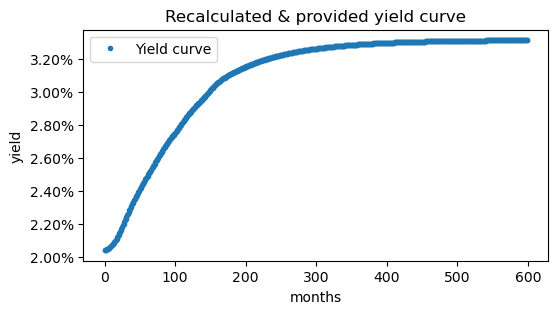

In [17]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(x_data_label, r_Target.values*100, color='tab:blue',label="Yield curve", marker='.', linestyle='')

ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("months")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

***

# Conclusion

This notebook calculated the Italian monthly yield curve using the EIOPA RFR calibration.

Note: As a check, the user can compare every 12-th value with the yield reported in the Excel file "EIOPA_RFR_20251231_Term_Structures.xlsx" or similar checks.

***
<span style=color:black>
    <b>Final monthly yield curve</b>
</span>
<br>
<span style=color:black>   
    Full yield curve provided by EIOPA but in monthly granularity
</span>

In [18]:
display(r_Target)

,Recalculated rates
0.083333,0.020424
0.166667,0.020436
0.250000,0.020452
0.333333,0.020472
0.416667,0.020495
...,...
49.666667,0.033104
49.750000,0.033104
49.833333,0.033104
49.916667,0.033104
